In [1]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('proj2.ok')

Assignment: proj2
OK, version v1.18.1



# Project 2: Predicting Taxi Ride Duration
## Due Date: 2021.6.11 (Fri) 11:59PM

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *list collaborators here*

## Score Breakdown
Question | Points
--- | ---
1a | 1
1b | 2
2a | 2
2b | 1
2c | 2
2d | 2
3a | 2
3b | 2
3c | 2
3d | 2
3e | 2
3f | 2
3g | 4
Total | 26

## This Assignment
In this project, you will use what you've learned in class to create a regression model that predicts the travel time of a taxi ride in New York. Some questions in this project are more substantial than those of past projects.

After this project, you should feel comfortable with the following:

- The data science lifecycle: data selection and cleaning, EDA, feature engineering, and model selection.
- Using `sklearn` to process data and fit linear regression models.
- Embedding linear regression as a component in a more complex model.

First, let's import:

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

## The Data

Run the following cell to load the cleaned Manhattan data.

In [3]:
manhattan_taxi = pd.read_csv('manhattan_taxi.csv')

Attributes of all [yellow taxi](https://en.wikipedia.org/wiki/Taxicabs_of_New_York_City) trips in January 2016 are published by the [NYC Taxi and Limosine Commission](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

Columns of the `manhattan_taxi` table include:
- `pickup_datetime`: date and time when the meter was engaged
- `dropoff_datetime`: date and time when the meter was disengaged
- `pickup_lon`: the longitude where the meter was engaged
- `pickup_lat`: the latitude where the meter was engaged
- `dropoff_lon`: the longitude where the meter was disengaged
- `dropoff_lat`: the latitude where the meter was disengaged
- `passengers`: the number of passengers in the vehicle (driver entered value)
- `distance`: trip distance
- `duration`: duration of the trip in seconds

Your goal will be to predict `duration` from the pick-up time, pick-up and drop-off locations, and distance.

In [4]:
manhattan_taxi.head()

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,2,3.99,981
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299
3,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470
4,2016-01-02 12:39:57,2016-01-02 12:53:29,-73.958214,40.760525,-73.983360,40.760406,1,1.70,812


A scatter diagram of only Manhattan taxi rides has the familiar shape of Manhattan Island.

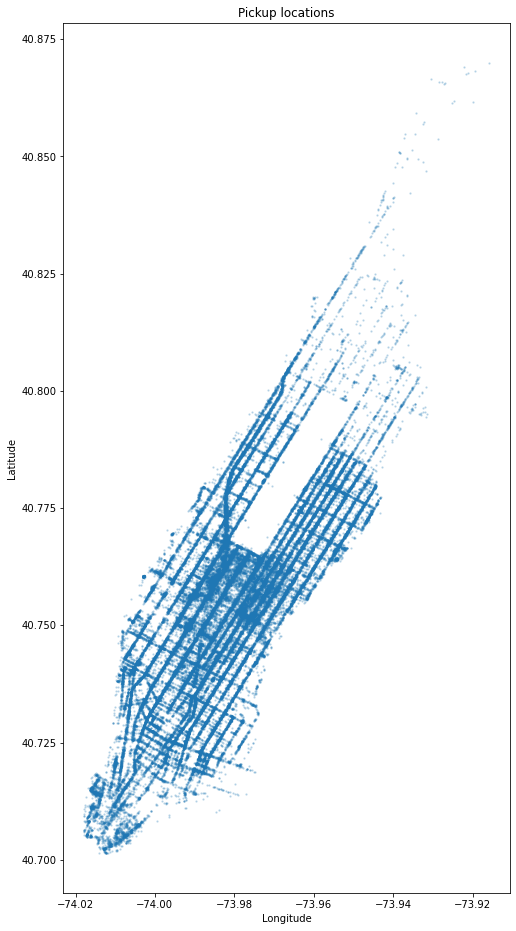

In [5]:
def pickup_scatter(t):
    plt.scatter(t['pickup_lon'], t['pickup_lat'], s=2, alpha=0.2)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Pickup locations')
    
plt.figure(figsize=(8, 16))
pickup_scatter(manhattan_taxi)

## Part 1: Exploratory Data Analysis

In this part, you'll choose which days to include as training data in your regression model. 

Your goal is to develop a general model that could potentially be used for future taxi rides. There is no guarantee that future distributions will resemble observed distributions, but some effort to limit training data to typical examples can help ensure that the training data are representative of future observations.

Note that January 2016 had some atypical days.
* New Years Day (January 1) fell on a Friday. 
* Martin Luther King Jr. Day was on Monday, January 18. 
* A [historic blizzard](https://en.wikipedia.org/wiki/January_2016_United_States_blizzard) passed through New York that month. 

Using this dataset to train a general regression model for taxi trip times must account for these unusual phenomena, and one way to account for them is to remove atypical days from the training data.

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Question 1a

Add a column labeled `date` to `manhattan_taxi` that contains the date (but not the time) of pickup, formatted as a `datetime.date` value ([docs](https://docs.python.org/3/library/datetime.html#date-objects)). 

*The provided tests check that you have extended `manhattan_taxi` correctly.*

<!--
BEGIN QUESTION
name: q2a
points: 1
-->

In [6]:
# BEGIN YOUR CODE
# -----------------------
manhattan_taxi.loc[:, 'date'] = manhattan_taxi['pickup_datetime'].str[:11]
manhattan_taxi['date'] = pd.to_datetime(manhattan_taxi['date'])

# -----------------------
# END YOUR CODE
manhattan_taxi

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration,date
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,2,3.99,981,2016-01-30
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320,2016-01-04
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299,2016-01-07
3,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470,2016-01-08
4,2016-01-02 12:39:57,2016-01-02 12:53:29,-73.958214,40.760525,-73.983360,40.760406,1,1.70,812,2016-01-02
...,...,...,...,...,...,...,...,...,...,...
82795,2016-01-31 02:59:16,2016-01-31 03:09:23,-73.997391,40.721027,-73.978447,40.745277,1,2.17,607,2016-01-31
82796,2016-01-14 22:48:10,2016-01-14 22:51:27,-73.988037,40.718761,-73.983337,40.726162,1,0.60,197,2016-01-14
82797,2016-01-08 04:46:37,2016-01-08 04:50:12,-73.984390,40.754978,-73.985909,40.751820,4,0.79,215,2016-01-08
82798,2016-01-31 12:55:54,2016-01-31 13:01:07,-74.008675,40.725979,-74.009598,40.716003,1,0.85,313,2016-01-31


In [7]:
ok.grade("q1a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Question 1b

Create a data visualization that allows you to identify which dates were affected by the historic blizzard of January 2016. Make sure that the visualization type is appropriate for the visualized data.

<!--
BEGIN QUESTION
name: q2b
points: 2
manual: True
format: image
-->
<!-- EXPORT TO PDF format:image -->

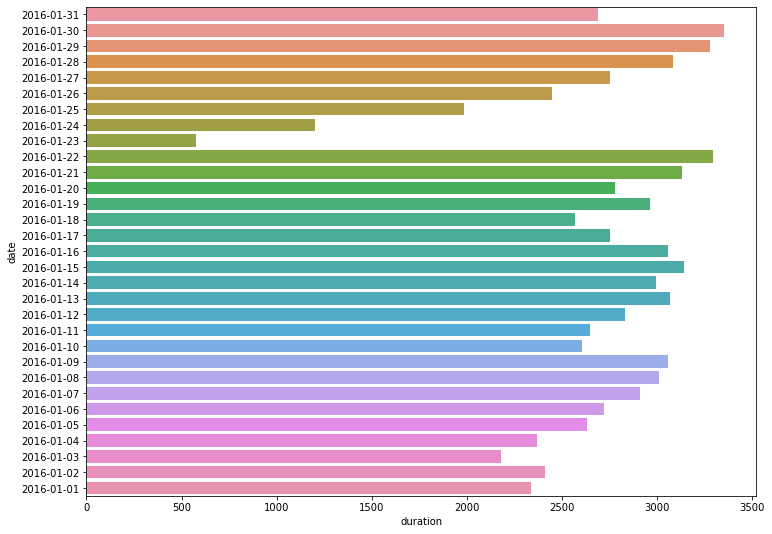

In [7]:
# BEGIN YOUR CODE
# -----------------------
date_count = manhattan_taxi[['date', 'duration']].groupby(by=  'date').agg('count')
date_count = date_count.reset_index()
date_count = date_count.sort_values(by = 'date', ascending = False)
date_count['date'] = date_count['date'].astype(str)
plt.figure(figsize=(12, 9))
sns.barplot(x = date_count['duration'], y = date_count['date'])
plt.show()
# -----------------------
# END YOUR CODE

Finally, we have generated a list of dates that should have a fairly typical distribution of taxi rides, which excludes holidays and blizzards. The cell below assigns `final_taxi` to the subset of `manhattan_taxi` that is on these days. (No changes are needed; just run this cell.)

In [8]:
import calendar
import re

from datetime import date

atypical = [1, 2, 3, 18, 23, 24, 25, 26]
typical_dates = [date(2016, 1, n) for n in range(1, 32) if n not in atypical]
typical_dates

print('Typical dates:\n')
pat = '  [1-3]|18 | 23| 24|25 |26 '
print(re.sub(pat, '   ', calendar.month(2016, 1)))

final_taxi = manhattan_taxi[manhattan_taxi['date'].isin(typical_dates)]

Typical dates:

    January 2016
Mo Tu We Th Fr Sa Su
                    
 4  5  6  7  8  9 10
11 12 13 14 15 16 17
   19 20 21 22      
      27 28 29 30 31



## Part 2: Feature Engineering

In this part, you'll create a design matrix (i.e., feature matrix) for your linear regression model. You decide to predict trip duration from the following inputs: start location, end location, trip distance, time of day, and day of the week (*Monday, Tuesday, etc.*). 

You will ensure that the process of transforming observations into a design matrix is expressed as a Python function called `design_matrix`, so that it's easy to make predictions for different samples in later parts of the project.

Because you are going to look at the data in detail in order to define features, it's best to split the data into training and test sets now, then only inspect the training set.

In [9]:
import sklearn.model_selection

train, test = sklearn.model_selection.train_test_split(final_taxi, train_size=0.8, test_size=0.2, random_state=42)

print('Train:', train.shape, 'Test:', test.shape)

Train: (53680, 10) Test: (13421, 10)


<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Question 2a

Use `sns.boxplot` to create a box plot that compares the distributions of taxi trip durations for each day **using `train` only**. Individual dates shoud appear on the horizontal axis, and duration values should appear on the vertical axis. Your plot should look like this:

![](images/3a_duration_by_date.png)


<!--
BEGIN QUESTION
name: q3a
points: 2
manual: True
format: image
-->
<!-- EXPORT TO PDF format:image -->

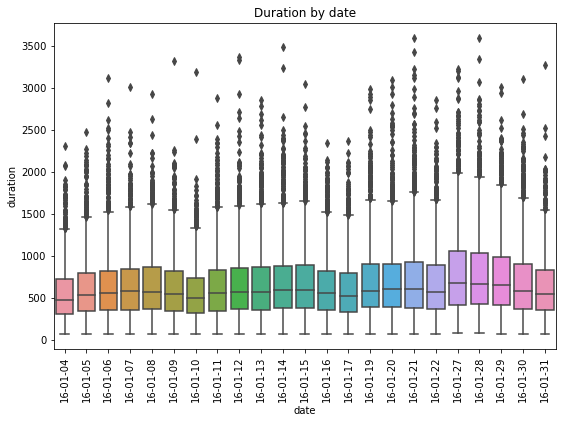

In [10]:
plt.figure(figsize=(9, 6))
# BEGIN YOUR CODE
# -----------------------
train = train.sort_values(by = 'date')
train['date'] = train['date'].astype(str)
train['date'] = train['date'].str[2:]
sns.boxplot(x = 'date', y = 'duration', data = train)
plt.xticks(rotation = 90 )
plt.title('Duration by date')
plt.show()
# -----------------------
# END YOUR CODE

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Question 2b

In one or two sentences, describe the assocation between the day of the week and the duration of a taxi trip. 

*Note*: The end of Part 2 showed a calendar for these dates and their corresponding days of the week.

<!--
BEGIN QUESTION
name: q3b
points: 1
manual: True
-->
<!-- EXPORT TO PDF -->

Answer: 주말에는 적은 분포를 보이며 월요일부터 시작하는 평일은 수요일까지 시간이 길어졌다가 다시 줄어듭니다. 10일과 17일에 가장 평균 지속시간이 낮은 경향을 보입니다.

Below, the provided `augment` function adds various columns to a taxi ride dataframe. 

- `hour`: The integer hour of the pickup time. E.g., a 3:45pm taxi ride would have `15` as the hour. A 12:20am ride would have `0`.
- `day`: The day of the week with Monday=0, Sunday=6.
- `weekend`: 1 if and only if the `day` is Saturday or Sunday.
- `period`: 1 for early morning (12am-6am), 2 for daytime (6am-6pm), and 3 for night (6pm-12pm).
- `speed`: Average speed in miles per hour.

No changes are required; just run this cell.

In [11]:
def speed(t):
    """Return a column of speeds in miles per hour."""
    return t['distance'] / t['duration'] * 60 * 60

def augment(t):
    """Augment a dataframe t with additional columns."""
    u = t.copy()
    pickup_time = pd.to_datetime(t['pickup_datetime'])
    u.loc[:, 'hour'] = pickup_time.dt.hour
    u.loc[:, 'day'] = pickup_time.dt.weekday
    u.loc[:, 'weekend'] = (pickup_time.dt.weekday >= 5).astype(int)
    u.loc[:, 'period'] = np.digitize(pickup_time.dt.hour, [0, 6, 18])
    u.loc[:, 'speed'] = speed(t)
    return u
    
train = augment(train)
test = augment(test)
train.iloc[0,:] # An example row

pickup_datetime     2016-01-04 07:28:16
dropoff_datetime    2016-01-04 07:33:17
pickup_lon                   -73.991875
pickup_lat                    40.764587
dropoff_lon                  -73.992142
dropoff_lat                   40.754906
passengers                            1
distance                           0.99
duration                            301
date                           16-01-04
hour                                  7
day                                   0
weekend                               0
period                                2
speed                         11.840532
Name: 23158, dtype: object

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Question 2c

Use `sns.distplot` to create an overlaid histogram comparing the distribution of average speeds for taxi rides that start in the early morning (12am-6am), day (6am-6pm; 12 hours), and night (6pm-12am; 6 hours). Your plot should look like this:

![](images/3c_speeds.png)

<!--
BEGIN QUESTION
name: q3c
points: 2
manual: True
format: image
-->
<!-- EXPORT TO PDF format:image -->

C:\Users\JJH\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\JJH\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\JJH\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level fun

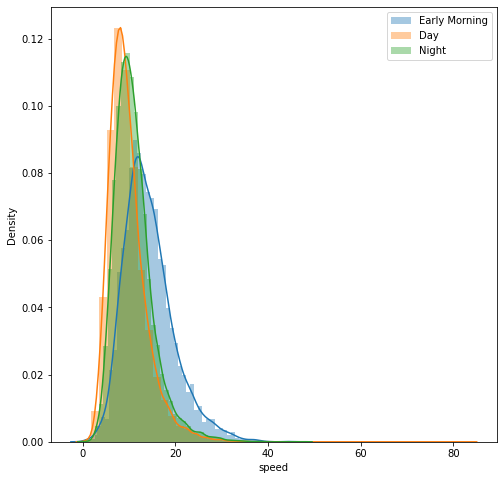

In [12]:
plt.figure(figsize=(8, 8))
# BEGIN YOUR CODE
# -----------------------
train['hour'] = train['hour'].astype(int)
sns.distplot(train[train['period'] == 1]['speed'], label = 'Early Morning')
sns.distplot(train[train['period'] == 2]['speed'], label = 'Day')
sns.distplot(train[train['period'] == 3]['speed'], label = 'Night')
plt.legend()
plt.show()

# -----------------------
# END YOUR CODE

It looks like the time of day is associated with the average speed of a taxi ride.

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Question 2d (PCA)

Manhattan can roughly be divided into Lower, Midtown, and Upper regions. Instead of studying a map, let's approximate by finding the first principal component of the pick-up location (latitude and longitude). 

* Add a `region` column to `train` that categorizes each pick-up location as 0, 1, or 2 based on the value of each point's first principal component, such that an equal number of points fall into each region. 

* Read the documentation of [`pd.qcut`](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.qcut.html), which categorizes points in a distribution into equal-frequency bins.

* You don't need to add any lines to this solution. Just fill in the assignment statements to complete the implementation.

*The provided tests ensure that you have answered the question correctly.*

<!--
BEGIN QUESTION
name: q3d
points: 2
-->

In [13]:
# Find the first principle component
D = train[['pickup_lon', 'pickup_lat']].values
pca_n = D.shape[0]
pca_means = np.mean(D, axis=0)
X = (D - pca_means) / np.sqrt(pca_n)
u, s, vt = np.linalg.svd(X, full_matrices=False)

def add_region(t):
    """Add a region column to t based on vt above."""
    # BEGIN YOUR CODE
    # -----------------------
    D = t[['pickup_lon', 'pickup_lat']].values
    assert D.shape[0] == t.shape[0], 'You set D using the incorrect table'
    
    # Always use the same data transformation used to compute vt
    X = (D-np.mean(D, axis=0)) / np.sqrt(D.shape[0])
    first_pc = X@ vt.T[:, 0]
    # -----------------------
    # END YOUR CODE
    t.loc[:,'region'] = pd.qcut(first_pc, 3, labels=[0, 1, 2])

add_region(train)
add_region(test)

In [31]:
ok.grade("q2d");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 7
    Failed: 0
[ooooooooook] 100.0% passed



Let's see how PCA divided the trips into three groups. These regions do roughly correspond to 
* Lower Manhattan (below 14th street)
* Midtown Manhattan (between 14th and the park)
* Upper Manhattan (bordering Central Park). 

No prior knowledge of New York geography was required!

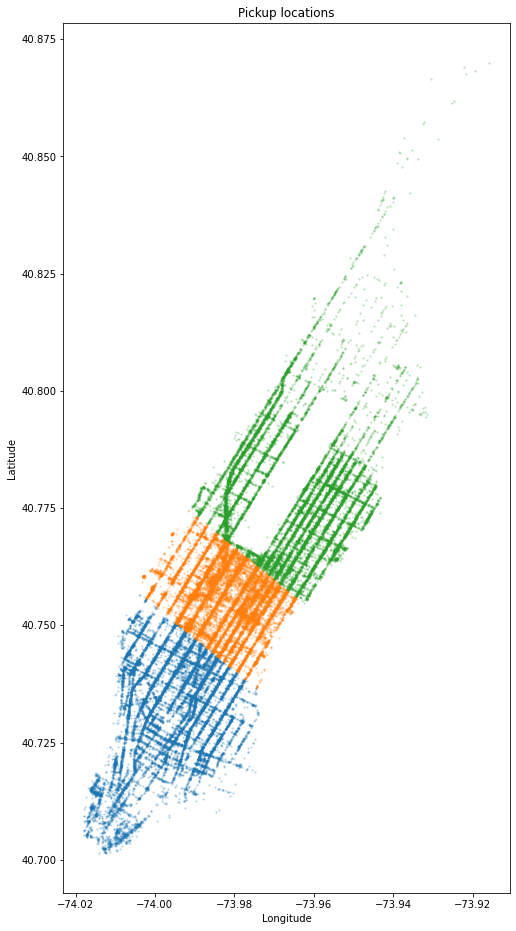

In [14]:
plt.figure(figsize=(8, 16))
for i in [0, 1, 2]:
    pickup_scatter(train[train['region'] == i])

Finally, we create a design matrix that includes many of these features. 
* Quantitative features are converted to standard units
* Categorical features are converted to dummy variables using one-hot encoding. 

Note that,
* The `period` is not included because it is a linear combination of the `hour`. 
* The `weekend` variable is not included because it is a linear combination of the `day`.
* The `speed` is not included because it was computed from the `duration` (it's impossible to know the speed without knowing the duration, given that you know the distance).

In [15]:
from sklearn.preprocessing import StandardScaler

num_vars = ['pickup_lon', 'pickup_lat', 'dropoff_lon', 'dropoff_lat', 'distance']
cat_vars = ['hour', 'day', 'region']

scaler = StandardScaler()
scaler.fit(train[num_vars])

def design_matrix(t):
    """Create a design matrix from taxi ride dataframe t."""
    scaled = t[num_vars].copy()
    scaled.iloc[:,:] = scaler.transform(scaled) # Convert to standard units
    categoricals = [pd.get_dummies(t[s], prefix=s, drop_first=True) for s in cat_vars]
    return pd.concat([scaled] + categoricals, axis=1)

design_matrix(train).iloc[0,:]  

pickup_lon    -0.661564
pickup_lat     0.464572
dropoff_lon   -0.693554
dropoff_lat   -0.052979
distance      -0.617017
hour_1         0.000000
hour_2         0.000000
hour_3         0.000000
hour_4         0.000000
hour_5         0.000000
hour_6         0.000000
hour_7         1.000000
hour_8         0.000000
hour_9         0.000000
hour_10        0.000000
hour_11        0.000000
hour_12        0.000000
hour_13        0.000000
hour_14        0.000000
hour_15        0.000000
hour_16        0.000000
hour_17        0.000000
hour_18        0.000000
hour_19        0.000000
hour_20        0.000000
hour_21        0.000000
hour_22        0.000000
hour_23        0.000000
day_1          0.000000
day_2          0.000000
day_3          0.000000
day_4          0.000000
day_5          0.000000
day_6          0.000000
region_1       1.000000
region_2       0.000000
Name: 23158, dtype: float64

## Part 3: Model Selection

In this part, you will select a regression model to predict the duration of a taxi ride.

**Important:** *Tests in this part do not confirm that you have answered correctly. Instead, they check that you're somewhat close in order to detect major errors. It is up to you to calculate the results correctly based on the question descriptions.*

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Question 3a

Assign `constant_rmse` to the root mean squared error on the test set for a constant model that always predicts the mean duration of all training set taxi rides.

<!--
BEGIN QUESTION
name: q4a
points: 2
-->

In [16]:
def rmse(errors):
    """Return the root mean squared error."""
    return np.sqrt(np.mean(errors ** 2))

# BEGIN YOUR CODE
# -----------------------
constant_rmse = rmse(test['duration'] - train['duration'].mean())
# -----------------------
# END YOUR CODE
constant_rmse

399.1437572352677

In [19]:
ok.grade("q3a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Question 3b

Assign `simple_rmse` to the root mean squared error on the test set for a simple linear regression model that uses only the distance of the taxi ride as a feature (and includes an intercept).

*Terminology Note*: Simple linear regression means that there is only one covariate. Multiple linear regression means that there is more than one. In either case, you can use the `LinearRegression` model from `sklearn` to fit the parameters to data.

<!--
BEGIN QUESTION
name: q4b
points: 2
-->

In [17]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
# BEGIN YOUR CODE
# -----------------------
model = LinearRegression()
y_train = train['duration']
model.fit(train[['distance']], y_train)
predictions = model.predict(test[['distance']])
# -----------------------
# END YOUR CODE
errors = predictions - test['duration']
simple_rmse = rmse(errors)
simple_rmse

276.78411050003353

In [21]:
ok.grade("q3b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Question 3c

Assign `linear_rmse` to the root mean squared error on the test set for a linear regression model fitted to the training set without regularization, using the design matrix defined by the `design_matrix` function from Part 3.

*The provided tests check that you have answered the question correctly and that your `design_matrix` function is working as intended.*

<!--
BEGIN QUESTION
name: q4c
points: 2
-->

In [18]:
model = LinearRegression()
# BEGIN YOUR CODE
# -----------------------
model.fit(design_matrix(train), train['duration'])
predictions = model.predict(design_matrix(test))
# -----------------------
# END YOUR CODE
errors = predictions - test['duration']
linear_rmse = rmse(errors)
linear_rmse

255.19146631882785

In [23]:
ok.grade("q3c");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Question 3d

For each possible value of `period`, fit an unregularized linear regression model to the subset of the training set in that `period`.  Assign `period_rmse` to the root mean squared error on the test set for a model that first chooses linear regression parameters based on the observed period of the taxi ride, then predicts the duration using those parameters. Again, fit to the training set and use the `design_matrix` function for features.

<!--
BEGIN QUESTION
name: q4d
points: 2
-->

In [19]:
model = LinearRegression()
errors = []

for v in np.unique(train['period']):
    # BEGIN YOUR CODE
    # -----------------------
    v_train = train[train['period']==v]
    v_test = test[test['period']==v]
    model.fit(design_matrix(v_train), train[train['period']==v]['duration'])
    predictions = model.predict(design_matrix(v_test))
    # -----------------------
    # END YOUR CODE
    errors.extend(predictions - v_test['duration'])
period_rmse = rmse(np.array(errors))
period_rmse

246.6286883116517

In [25]:
ok.grade("q3d");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



This approach is a simple form of decision tree regression, where a different regression function is estimated for each possible choice among a collection of choices. In this case, the depth of the tree is only 1.

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Question 3e

In one or two sentences, explain how the `period` regression model could possibly outperform linear regression when the design matrix for linear regression already includes one feature for each possible hour, which can be combined linearly to determine the `period` value.

<!--
BEGIN QUESTION
name: q4e
points: 2
manual: True
-->
<!-- EXPORT TO PDF -->

Answer: period 회귀 모델은 각 기간 내에 예측하기 때문에 예측을 방해하는 다른 period의 승차 효과에 대한 효과가 훨씬 적게 작용합니다. 전체 period에 대한 하나의 선형 예측이 아닌 각 period에 대해 각각의 선형 예측을 합침시킴으로써 더 나은 선형 회귀 결과를 얻을 수 있습니다.

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Question 3f

Instead of predicting duration directly, an alternative is to predict the average *speed* of the taxi ride using linear regression, then compute an estimate of the duration from the predicted speed and observed distance for each ride.

Assign `speed_rmse` to the root mean squared error in the **duration** predicted by a model that first predicts speed as a linear combination of features from the `design_matrix` function, fitted on the training set, then predicts duration from the predicted speed and observed distance.

*Hint*: Speed is in miles per hour, but duration is measured in seconds. You'll need the fact that there are 60 * 60 = 3,600 seconds in an hour.

<!--
BEGIN QUESTION
name: q4f
points: 2
-->

In [20]:
model = LinearRegression()
# BEGIN YOUR CODE
# -----------------------
model.fit(design_matrix(train), train['speed'])
speed_predictions = model.predict(design_matrix(test))
duration_predictions = test['distance']/ speed_predictions*3600 
# -----------------------
# END YOUR CODE
errors = duration_predictions - test['duration']
speed_rmse = rmse(errors)
speed_rmse

243.0179836851497

In [27]:
ok.grade("q3f");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



Here's a summary of your results:

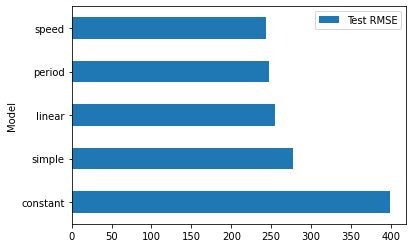

In [21]:
models = ['constant', 'simple', 'linear', 'period', 'speed']
pd.DataFrame.from_dict({
    'Model': models,
    'Test RMSE': [eval(m + '_rmse') for m in models]
}).set_index('Model').plot(kind='barh');

## Congratulations! 

You've carried out the entire data science lifecycle for a challenging regression problem. 

* In Part 1 on `EDA`, you used the data to assess the impact of a historical event---the 2016 blizzard---and filtered the data accordingly.

* In Part 2 on `feature engineering`, you used PCA to divide up the map of Manhattan into regions that roughly corresponded to the standard geographic description of the island.

* In Part 3 on `model selection`, you found that using linear regression in practice can involve more than just choosing a design matrix. Tree regression made better use of categorical variables than linear regression. The domain knowledge that duration is a simple function of distance and speed allowed you to predict duration more accurately by first predicting speed.

Hopefully, it is apparent that all of these steps are required to reach a reliable conclusion about what inputs and model structure are helpful in predicting the duration of a taxi ride in Manhattan. 

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Congratulations! You have completed Project 2.

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.,

**Please save before submitting!**

Please generate pdf as follows and submit it to Gradescope.

**File > Print Preview > Print > Save as pdf**

<!-- EXPECT 6 EXPORTED QUESTIONS -->